In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

import torchvision.models as models
from torchvision import transforms

from PIL import Image
import numpy as np
import pandas as pd
import os

class FlowerDataset(Dataset):
    def __init__(self, image_dir, image_paths, label_file, transform=None):
        self.image_dir = image_dir
        self.labels = np.load(label_file)
        self.image_label_pairs = self._load_paths(image_paths)
        self.transform = transform
        
    def train_val_test_split(self, train_ratio, val_ratio):
        dataset_length = len(self.image_label_pairs)
        train_length = int(train_ratio * dataset_length)
        val_length = int(val_ratio * dataset_length)
        test_length = len(self) - train_length - val_length
        splits = [train_length, val_length, test_length]
        return random_split(self, splits)
        
    def _load_paths(self, file_path):
        """
        params:  file_path, a path pointing to where the image paths are stored.
        returns: dictionary with keys 'full_image_path', and values 'label'
        """
        split_set = {}
        with open(file_path) as f:
            lines = f.readlines()
            num_lines = len(lines)
            assert(num_lines == len(self.labels))
            for line_num in range(num_lines):
                full_image_path = os.path.join(self.image_dir, lines[line_num].strip('\n'))
                split_set[full_image_path] = self.labels[line_num]
        return pd.DataFrame.from_dict(split_set, orient='index')
        
    def _load_image(self, image_path):
        img = Image.open(image_path)
        img.load()
        img = np.array(img)
        if len(img.shape) == 2:
            img = np.expand_dims(img, 2)
            img = np.repeat(img, 3, 2)
        return Image.fromarray(img)
        
    def __len__(self):
        return len(self.image_label_pairs)
    
    def __getitem__(self, idx):
        # apply transforms
        image_path = self.image_label_pairs.index[idx]
        image = self._load_image(image_path)
        if self.transform is not None:
            image = self.transform(image)
        label = self.labels[idx]
        return {'image': image,
                'label': label}
    
transform = transforms.Compose([transforms.CenterCrop(200), transforms.ToTensor()])
dataset = FlowerDataset('data', 'image_paths.txt', 'labels.npy', transform=transform)
train_set, val_set, test_set = dataset.train_val_test_split(0.7, 0.1)


train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True, num_workers=4)

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_losses = []
    for idx, batch in enumerate(train_loader):
        data, target = batch['image'].to(device), batch['label'].long().to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = CE(output, target)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        print('Epoch: {}, Samples: {}/{}, Loss: {}'.format(epoch, idx*batch_size,
                                                           len(train_loader)*batch_size,
                                                           loss.item()))
    train_loss = torch.mean(torch.tensor(train_losses))
    print('\nEpoch: {}'.format(epoch))
    print('Training set: Average loss: {:.4f}'.format(train_loss))
    
    return train_loss

def validate(model, device, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    
    with torch.no_grad():
        for _, batch in enumerate(val_loader):
            data, target = batch['image'].to(device), batch['label'].long().to(device)
            output = model(data)
            
            # compute the batch loss
            batch_loss = CE(output, target).item()
            val_loss += batch_loss
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    # divide by the number of batches of batch size 32
    # get the average validation over all bins
    val_loss /= len(val_loader)
    print('Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        val_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    
    return val_loss

DATA_DIRECTORY = 'data/'
use_cuda = 1
batch_size = 32
num_epochs = 50
learning_rate = 1e-3

device = torch.device("cuda" if use_cuda else "cpu")
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(512, 102)
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
CE = nn.CrossEntropyLoss()

train_losses = []
val_losses = []

for epoch in range(1, num_epochs + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch)
    val_loss = validate(model, device, val_loader)

    if (len(val_losses) > 0) and (val_loss < min(val_losses)):
        torch.save(model.state_dict(), "best_model.pt")
        print("Saving model (epoch {}) with lowest validation loss: {}"
              .format(epoch, val_loss))

    train_losses.append(train_loss)
    val_losses.append(val_loss)

print("Training and validation complete.")

Epoch: 1, Samples: 0/5760, Loss: 4.981675624847412
Epoch: 1, Samples: 32/5760, Loss: 5.093235492706299
Epoch: 1, Samples: 64/5760, Loss: 4.838579177856445
Epoch: 1, Samples: 96/5760, Loss: 4.988086700439453
Epoch: 1, Samples: 128/5760, Loss: 4.844787120819092
Epoch: 1, Samples: 160/5760, Loss: 4.841336250305176
Epoch: 1, Samples: 192/5760, Loss: 4.810749530792236
Epoch: 1, Samples: 224/5760, Loss: 4.851246356964111
Epoch: 1, Samples: 256/5760, Loss: 4.909475803375244
Epoch: 1, Samples: 288/5760, Loss: 4.735227584838867
Epoch: 1, Samples: 320/5760, Loss: 4.785477638244629
Epoch: 1, Samples: 352/5760, Loss: 4.52473783493042
Epoch: 1, Samples: 384/5760, Loss: 4.818118095397949
Epoch: 1, Samples: 416/5760, Loss: 4.818408966064453
Epoch: 1, Samples: 448/5760, Loss: 4.7100510597229
Epoch: 1, Samples: 480/5760, Loss: 4.6769890785217285
Epoch: 1, Samples: 512/5760, Loss: 4.601886749267578
Epoch: 1, Samples: 544/5760, Loss: 4.516341209411621
Epoch: 1, Samples: 576/5760, Loss: 4.565003395080566


Epoch: 1, Samples: 4864/5760, Loss: 3.109308958053589
Epoch: 1, Samples: 4896/5760, Loss: 2.5502212047576904
Epoch: 1, Samples: 4928/5760, Loss: 2.6242527961730957
Epoch: 1, Samples: 4960/5760, Loss: 2.5027661323547363
Epoch: 1, Samples: 4992/5760, Loss: 2.4958298206329346
Epoch: 1, Samples: 5024/5760, Loss: 2.8655614852905273
Epoch: 1, Samples: 5056/5760, Loss: 2.970979690551758
Epoch: 1, Samples: 5088/5760, Loss: 2.8893725872039795
Epoch: 1, Samples: 5120/5760, Loss: 3.3477981090545654
Epoch: 1, Samples: 5152/5760, Loss: 2.7707324028015137
Epoch: 1, Samples: 5184/5760, Loss: 2.5357718467712402
Epoch: 1, Samples: 5216/5760, Loss: 2.825629472732544
Epoch: 1, Samples: 5248/5760, Loss: 2.8034169673919678
Epoch: 1, Samples: 5280/5760, Loss: 2.5551035404205322
Epoch: 1, Samples: 5312/5760, Loss: 2.763857364654541
Epoch: 1, Samples: 5344/5760, Loss: 2.806051015853882
Epoch: 1, Samples: 5376/5760, Loss: 3.1017913818359375
Epoch: 1, Samples: 5408/5760, Loss: 2.909381151199341
Epoch: 1, Sample

Epoch: 2, Samples: 3872/5760, Loss: 1.6289026737213135
Epoch: 2, Samples: 3904/5760, Loss: 1.7575404644012451
Epoch: 2, Samples: 3936/5760, Loss: 1.4349433183670044
Epoch: 2, Samples: 3968/5760, Loss: 2.1443421840667725
Epoch: 2, Samples: 4000/5760, Loss: 1.6541441679000854
Epoch: 2, Samples: 4032/5760, Loss: 1.6755552291870117
Epoch: 2, Samples: 4064/5760, Loss: 1.542382001876831
Epoch: 2, Samples: 4096/5760, Loss: 1.136785626411438
Epoch: 2, Samples: 4128/5760, Loss: 1.722957730293274
Epoch: 2, Samples: 4160/5760, Loss: 1.4699292182922363
Epoch: 2, Samples: 4192/5760, Loss: 1.5440130233764648
Epoch: 2, Samples: 4224/5760, Loss: 1.6578527688980103
Epoch: 2, Samples: 4256/5760, Loss: 1.8082846403121948
Epoch: 2, Samples: 4288/5760, Loss: 1.913496732711792
Epoch: 2, Samples: 4320/5760, Loss: 1.6602660417556763
Epoch: 2, Samples: 4352/5760, Loss: 1.4613606929779053
Epoch: 2, Samples: 4384/5760, Loss: 1.7006946802139282
Epoch: 2, Samples: 4416/5760, Loss: 1.4747889041900635
Epoch: 2, Samp

Epoch: 3, Samples: 2816/5760, Loss: 0.7566046714782715
Epoch: 3, Samples: 2848/5760, Loss: 0.9338341355323792
Epoch: 3, Samples: 2880/5760, Loss: 1.028013825416565
Epoch: 3, Samples: 2912/5760, Loss: 1.0444105863571167
Epoch: 3, Samples: 2944/5760, Loss: 0.8622292876243591
Epoch: 3, Samples: 2976/5760, Loss: 0.9319918751716614
Epoch: 3, Samples: 3008/5760, Loss: 0.9869404435157776
Epoch: 3, Samples: 3040/5760, Loss: 1.0346956253051758
Epoch: 3, Samples: 3072/5760, Loss: 1.1696256399154663
Epoch: 3, Samples: 3104/5760, Loss: 1.0973968505859375
Epoch: 3, Samples: 3136/5760, Loss: 1.1926771402359009
Epoch: 3, Samples: 3168/5760, Loss: 1.004628300666809
Epoch: 3, Samples: 3200/5760, Loss: 1.1826084852218628
Epoch: 3, Samples: 3232/5760, Loss: 1.0404101610183716
Epoch: 3, Samples: 3264/5760, Loss: 0.9176484942436218
Epoch: 3, Samples: 3296/5760, Loss: 1.2525078058242798
Epoch: 3, Samples: 3328/5760, Loss: 0.9921475052833557
Epoch: 3, Samples: 3360/5760, Loss: 0.9892899990081787
Epoch: 3, Sa

Epoch: 4, Samples: 1760/5760, Loss: 0.8127442598342896
Epoch: 4, Samples: 1792/5760, Loss: 0.7711822390556335
Epoch: 4, Samples: 1824/5760, Loss: 1.097281575202942
Epoch: 4, Samples: 1856/5760, Loss: 0.8611927032470703
Epoch: 4, Samples: 1888/5760, Loss: 0.5673954486846924
Epoch: 4, Samples: 1920/5760, Loss: 0.7456719875335693
Epoch: 4, Samples: 1952/5760, Loss: 0.6199333667755127
Epoch: 4, Samples: 1984/5760, Loss: 0.7084217667579651
Epoch: 4, Samples: 2016/5760, Loss: 0.9151898622512817
Epoch: 4, Samples: 2048/5760, Loss: 1.3497066497802734
Epoch: 4, Samples: 2080/5760, Loss: 0.6168617010116577
Epoch: 4, Samples: 2112/5760, Loss: 0.8581717014312744
Epoch: 4, Samples: 2144/5760, Loss: 0.7511909008026123
Epoch: 4, Samples: 2176/5760, Loss: 0.7797274589538574
Epoch: 4, Samples: 2208/5760, Loss: 0.517604410648346
Epoch: 4, Samples: 2240/5760, Loss: 0.5592511296272278
Epoch: 4, Samples: 2272/5760, Loss: 0.7449363470077515
Epoch: 4, Samples: 2304/5760, Loss: 1.050944447517395
Epoch: 4, Sam

Epoch: 5, Samples: 704/5760, Loss: 0.7530789375305176
Epoch: 5, Samples: 736/5760, Loss: 0.34818369150161743
Epoch: 5, Samples: 768/5760, Loss: 0.4311977028846741
Epoch: 5, Samples: 800/5760, Loss: 0.5927693247795105
Epoch: 5, Samples: 832/5760, Loss: 0.5341148972511292
Epoch: 5, Samples: 864/5760, Loss: 0.5135416984558105
Epoch: 5, Samples: 896/5760, Loss: 0.4947529435157776
Epoch: 5, Samples: 928/5760, Loss: 0.6943727731704712
Epoch: 5, Samples: 960/5760, Loss: 0.8102668523788452
Epoch: 5, Samples: 992/5760, Loss: 0.5628613829612732
Epoch: 5, Samples: 1024/5760, Loss: 0.7019474506378174
Epoch: 5, Samples: 1056/5760, Loss: 0.5515800714492798
Epoch: 5, Samples: 1088/5760, Loss: 0.5524475574493408
Epoch: 5, Samples: 1120/5760, Loss: 0.49519604444503784
Epoch: 5, Samples: 1152/5760, Loss: 0.5163905024528503
Epoch: 5, Samples: 1184/5760, Loss: 0.6310302019119263
Epoch: 5, Samples: 1216/5760, Loss: 0.6831123232841492
Epoch: 5, Samples: 1248/5760, Loss: 0.5550491809844971
Epoch: 5, Samples:

Epoch: 5, Samples: 5472/5760, Loss: 0.46549928188323975
Epoch: 5, Samples: 5504/5760, Loss: 0.5959598422050476
Epoch: 5, Samples: 5536/5760, Loss: 0.6651023626327515
Epoch: 5, Samples: 5568/5760, Loss: 0.39048337936401367
Epoch: 5, Samples: 5600/5760, Loss: 0.4273005723953247
Epoch: 5, Samples: 5632/5760, Loss: 0.571307361125946
Epoch: 5, Samples: 5664/5760, Loss: 0.4915602207183838
Epoch: 5, Samples: 5696/5760, Loss: 0.30192968249320984
Epoch: 5, Samples: 5728/5760, Loss: 2.18290114402771

Epoch: 5
Training set: Average loss: 0.5453
Validation set: Average loss: 0.6160, Accuracy: 730/818 (89%)
Saving model (epoch 5) with lowest validation loss: 0.6160411078196305
Epoch: 6, Samples: 0/5760, Loss: 0.27340954542160034
Epoch: 6, Samples: 32/5760, Loss: 0.28851816058158875
Epoch: 6, Samples: 64/5760, Loss: 0.3234747350215912
Epoch: 6, Samples: 96/5760, Loss: 0.5552862286567688
Epoch: 6, Samples: 128/5760, Loss: 0.2679573893547058
Epoch: 6, Samples: 160/5760, Loss: 0.3460949659347534
Epoch:

Epoch: 6, Samples: 4384/5760, Loss: 0.3203886151313782
Epoch: 6, Samples: 4416/5760, Loss: 0.34222128987312317
Epoch: 6, Samples: 4448/5760, Loss: 0.23326678574085236
Epoch: 6, Samples: 4480/5760, Loss: 0.6470291018486023
Epoch: 6, Samples: 4512/5760, Loss: 0.3444872498512268
Epoch: 6, Samples: 4544/5760, Loss: 0.46906983852386475
Epoch: 6, Samples: 4576/5760, Loss: 0.47931692004203796
Epoch: 6, Samples: 4608/5760, Loss: 0.15777254104614258
Epoch: 6, Samples: 4640/5760, Loss: 0.34527674317359924
Epoch: 6, Samples: 4672/5760, Loss: 0.2804027199745178
Epoch: 6, Samples: 4704/5760, Loss: 0.2932080030441284
Epoch: 6, Samples: 4736/5760, Loss: 0.47870349884033203
Epoch: 6, Samples: 4768/5760, Loss: 0.35901546478271484
Epoch: 6, Samples: 4800/5760, Loss: 0.40276670455932617
Epoch: 6, Samples: 4832/5760, Loss: 0.24440395832061768
Epoch: 6, Samples: 4864/5760, Loss: 0.4076423645019531
Epoch: 6, Samples: 4896/5760, Loss: 0.596919059753418
Epoch: 6, Samples: 4928/5760, Loss: 0.40428581833839417


Epoch: 7, Samples: 3296/5760, Loss: 0.22356490790843964
Epoch: 7, Samples: 3328/5760, Loss: 0.29653894901275635
Epoch: 7, Samples: 3360/5760, Loss: 0.2633354067802429
Epoch: 7, Samples: 3392/5760, Loss: 0.2492700219154358
Epoch: 7, Samples: 3424/5760, Loss: 0.4279276728630066
Epoch: 7, Samples: 3456/5760, Loss: 0.16600210964679718
Epoch: 7, Samples: 3488/5760, Loss: 0.32370054721832275
Epoch: 7, Samples: 3520/5760, Loss: 0.12914638221263885
Epoch: 7, Samples: 3552/5760, Loss: 0.18746666610240936
Epoch: 7, Samples: 3584/5760, Loss: 0.2929116487503052
Epoch: 7, Samples: 3616/5760, Loss: 0.21340669691562653
Epoch: 7, Samples: 3648/5760, Loss: 0.2633639872074127
Epoch: 7, Samples: 3680/5760, Loss: 0.3188667893409729
Epoch: 7, Samples: 3712/5760, Loss: 0.24157989025115967
Epoch: 7, Samples: 3744/5760, Loss: 0.2625085413455963
Epoch: 7, Samples: 3776/5760, Loss: 0.30865007638931274
Epoch: 7, Samples: 3808/5760, Loss: 0.2830255329608917
Epoch: 7, Samples: 3840/5760, Loss: 0.27433809638023376


Epoch: 8, Samples: 2176/5760, Loss: 0.21107220649719238
Epoch: 8, Samples: 2208/5760, Loss: 0.23855745792388916
Epoch: 8, Samples: 2240/5760, Loss: 0.2163565754890442
Epoch: 8, Samples: 2272/5760, Loss: 0.17361459136009216
Epoch: 8, Samples: 2304/5760, Loss: 0.355289101600647
Epoch: 8, Samples: 2336/5760, Loss: 0.15230898559093475
Epoch: 8, Samples: 2368/5760, Loss: 0.11606496572494507
Epoch: 8, Samples: 2400/5760, Loss: 0.13726544380187988
Epoch: 8, Samples: 2432/5760, Loss: 0.24764931201934814
Epoch: 8, Samples: 2464/5760, Loss: 0.24620309472084045
Epoch: 8, Samples: 2496/5760, Loss: 0.26034486293792725
Epoch: 8, Samples: 2528/5760, Loss: 0.3048785924911499
Epoch: 8, Samples: 2560/5760, Loss: 0.12190283834934235
Epoch: 8, Samples: 2592/5760, Loss: 0.2063509225845337
Epoch: 8, Samples: 2624/5760, Loss: 0.14655186235904694
Epoch: 8, Samples: 2656/5760, Loss: 0.16030465066432953
Epoch: 8, Samples: 2688/5760, Loss: 0.33563557267189026
Epoch: 8, Samples: 2720/5760, Loss: 0.166355580091476

Epoch: 9, Samples: 1056/5760, Loss: 0.13632002472877502
Epoch: 9, Samples: 1088/5760, Loss: 0.14102719724178314
Epoch: 9, Samples: 1120/5760, Loss: 0.20720252394676208
Epoch: 9, Samples: 1152/5760, Loss: 0.11415794491767883
Epoch: 9, Samples: 1184/5760, Loss: 0.2159465104341507
Epoch: 9, Samples: 1216/5760, Loss: 0.11395163834095001
Epoch: 9, Samples: 1248/5760, Loss: 0.11009016633033752
Epoch: 9, Samples: 1280/5760, Loss: 0.16646844148635864
Epoch: 9, Samples: 1312/5760, Loss: 0.13615332543849945
Epoch: 9, Samples: 1344/5760, Loss: 0.09483759105205536
Epoch: 9, Samples: 1376/5760, Loss: 0.12000858783721924
Epoch: 9, Samples: 1408/5760, Loss: 0.23929433524608612
Epoch: 9, Samples: 1440/5760, Loss: 0.11000195145606995
Epoch: 9, Samples: 1472/5760, Loss: 0.15311303734779358
Epoch: 9, Samples: 1504/5760, Loss: 0.1857897788286209
Epoch: 9, Samples: 1536/5760, Loss: 0.1468057483434677
Epoch: 9, Samples: 1568/5760, Loss: 0.15960437059402466
Epoch: 9, Samples: 1600/5760, Loss: 0.0878563672304

Validation set: Average loss: 0.4285, Accuracy: 741/818 (91%)
Epoch: 10, Samples: 0/5760, Loss: 0.0632612407207489
Epoch: 10, Samples: 32/5760, Loss: 0.11526094377040863
Epoch: 10, Samples: 64/5760, Loss: 0.06662280857563019
Epoch: 10, Samples: 96/5760, Loss: 0.07758261263370514
Epoch: 10, Samples: 128/5760, Loss: 0.10655315220355988
Epoch: 10, Samples: 160/5760, Loss: 0.1144159734249115
Epoch: 10, Samples: 192/5760, Loss: 0.16287676990032196
Epoch: 10, Samples: 224/5760, Loss: 0.13798481225967407
Epoch: 10, Samples: 256/5760, Loss: 0.07823912799358368
Epoch: 10, Samples: 288/5760, Loss: 0.0933220237493515
Epoch: 10, Samples: 320/5760, Loss: 0.10903230309486389
Epoch: 10, Samples: 352/5760, Loss: 0.130917489528656
Epoch: 10, Samples: 384/5760, Loss: 0.17921048402786255
Epoch: 10, Samples: 416/5760, Loss: 0.07767616212368011
Epoch: 10, Samples: 448/5760, Loss: 0.07844151556491852
Epoch: 10, Samples: 480/5760, Loss: 0.22872382402420044
Epoch: 10, Samples: 512/5760, Loss: 0.18824678659439

Epoch: 10, Samples: 4608/5760, Loss: 0.08371695876121521
Epoch: 10, Samples: 4640/5760, Loss: 0.0960046648979187
Epoch: 10, Samples: 4672/5760, Loss: 0.12044525146484375
Epoch: 10, Samples: 4704/5760, Loss: 0.1144823431968689
Epoch: 10, Samples: 4736/5760, Loss: 0.14977143704891205
Epoch: 10, Samples: 4768/5760, Loss: 0.12794330716133118
Epoch: 10, Samples: 4800/5760, Loss: 0.1028425544500351
Epoch: 10, Samples: 4832/5760, Loss: 0.1124931126832962
Epoch: 10, Samples: 4864/5760, Loss: 0.10634084045886993
Epoch: 10, Samples: 4896/5760, Loss: 0.1495128870010376
Epoch: 10, Samples: 4928/5760, Loss: 0.20256467163562775
Epoch: 10, Samples: 4960/5760, Loss: 0.3111112713813782
Epoch: 10, Samples: 4992/5760, Loss: 0.09062990546226501
Epoch: 10, Samples: 5024/5760, Loss: 0.1064104288816452
Epoch: 10, Samples: 5056/5760, Loss: 0.18886174261569977
Epoch: 10, Samples: 5088/5760, Loss: 0.1736472249031067
Epoch: 10, Samples: 5120/5760, Loss: 0.07432104647159576
Epoch: 10, Samples: 5152/5760, Loss: 0.

Epoch: 11, Samples: 3392/5760, Loss: 0.08129246532917023
Epoch: 11, Samples: 3424/5760, Loss: 0.11833707988262177
Epoch: 11, Samples: 3456/5760, Loss: 0.04319038987159729
Epoch: 11, Samples: 3488/5760, Loss: 0.06040504574775696
Epoch: 11, Samples: 3520/5760, Loss: 0.09731727838516235
Epoch: 11, Samples: 3552/5760, Loss: 0.15809796750545502
Epoch: 11, Samples: 3584/5760, Loss: 0.0737757682800293
Epoch: 11, Samples: 3616/5760, Loss: 0.14370107650756836
Epoch: 11, Samples: 3648/5760, Loss: 0.12101805210113525
Epoch: 11, Samples: 3680/5760, Loss: 0.045200422406196594
Epoch: 11, Samples: 3712/5760, Loss: 0.09654557704925537
Epoch: 11, Samples: 3744/5760, Loss: 0.05417138338088989
Epoch: 11, Samples: 3776/5760, Loss: 0.20917831361293793
Epoch: 11, Samples: 3808/5760, Loss: 0.0995863676071167
Epoch: 11, Samples: 3840/5760, Loss: 0.07100257277488708
Epoch: 11, Samples: 3872/5760, Loss: 0.08590532839298248
Epoch: 11, Samples: 3904/5760, Loss: 0.08010494709014893
Epoch: 11, Samples: 3936/5760, L

Epoch: 12, Samples: 2176/5760, Loss: 0.06713055074214935
Epoch: 12, Samples: 2208/5760, Loss: 0.03550627827644348
Epoch: 12, Samples: 2240/5760, Loss: 0.05243200063705444
Epoch: 12, Samples: 2272/5760, Loss: 0.07413475215435028
Epoch: 12, Samples: 2304/5760, Loss: 0.09703060984611511
Epoch: 12, Samples: 2336/5760, Loss: 0.061816394329071045
Epoch: 12, Samples: 2368/5760, Loss: 0.045688197016716
Epoch: 12, Samples: 2400/5760, Loss: 0.07205472886562347
Epoch: 12, Samples: 2432/5760, Loss: 0.072712242603302
Epoch: 12, Samples: 2464/5760, Loss: 0.11780250072479248
Epoch: 12, Samples: 2496/5760, Loss: 0.06299805641174316
Epoch: 12, Samples: 2528/5760, Loss: 0.06038016080856323
Epoch: 12, Samples: 2560/5760, Loss: 0.15312370657920837
Epoch: 12, Samples: 2592/5760, Loss: 0.054661065340042114
Epoch: 12, Samples: 2624/5760, Loss: 0.038816899061203
Epoch: 12, Samples: 2656/5760, Loss: 0.14272698760032654
Epoch: 12, Samples: 2688/5760, Loss: 0.10904043912887573
Epoch: 12, Samples: 2720/5760, Loss

Epoch: 13, Samples: 992/5760, Loss: 0.07383483648300171
Epoch: 13, Samples: 1024/5760, Loss: 0.0823897272348404
Epoch: 13, Samples: 1056/5760, Loss: 0.06949789822101593
Epoch: 13, Samples: 1088/5760, Loss: 0.04895015060901642
Epoch: 13, Samples: 1120/5760, Loss: 0.041682541370391846
Epoch: 13, Samples: 1152/5760, Loss: 0.06307250261306763
Epoch: 13, Samples: 1184/5760, Loss: 0.06070666015148163
Epoch: 13, Samples: 1216/5760, Loss: 0.09530894458293915
Epoch: 13, Samples: 1248/5760, Loss: 0.05822652578353882
Epoch: 13, Samples: 1280/5760, Loss: 0.08745963871479034
Epoch: 13, Samples: 1312/5760, Loss: 0.07380671799182892
Epoch: 13, Samples: 1344/5760, Loss: 0.04413576424121857
Epoch: 13, Samples: 1376/5760, Loss: 0.07125526666641235
Epoch: 13, Samples: 1408/5760, Loss: 0.05188557505607605
Epoch: 13, Samples: 1440/5760, Loss: 0.068735271692276
Epoch: 13, Samples: 1472/5760, Loss: 0.047585681080818176
Epoch: 13, Samples: 1504/5760, Loss: 0.06542667746543884
Epoch: 13, Samples: 1536/5760, Lo

Epoch: 13, Samples: 5600/5760, Loss: 0.11015938222408295
Epoch: 13, Samples: 5632/5760, Loss: 0.07739381492137909
Epoch: 13, Samples: 5664/5760, Loss: 0.11267164349555969
Epoch: 13, Samples: 5696/5760, Loss: 0.029019713401794434
Epoch: 13, Samples: 5728/5760, Loss: 0.8167370557785034

Epoch: 13
Training set: Average loss: 0.0762
Validation set: Average loss: 0.3358, Accuracy: 757/818 (93%)
Saving model (epoch 13) with lowest validation loss: 0.335828005694426
Epoch: 14, Samples: 0/5760, Loss: 0.0728921890258789
Epoch: 14, Samples: 32/5760, Loss: 0.04144415259361267
Epoch: 14, Samples: 64/5760, Loss: 0.04003074765205383
Epoch: 14, Samples: 96/5760, Loss: 0.05770152807235718
Epoch: 14, Samples: 128/5760, Loss: 0.06288303434848785
Epoch: 14, Samples: 160/5760, Loss: 0.04578763246536255
Epoch: 14, Samples: 192/5760, Loss: 0.06556856632232666
Epoch: 14, Samples: 224/5760, Loss: 0.06621196866035461
Epoch: 14, Samples: 256/5760, Loss: 0.09798245131969452
Epoch: 14, Samples: 288/5760, Loss: 0.

Epoch: 14, Samples: 4352/5760, Loss: 0.05575290322303772
Epoch: 14, Samples: 4384/5760, Loss: 0.07735064625740051
Epoch: 14, Samples: 4416/5760, Loss: 0.08877164125442505
Epoch: 14, Samples: 4448/5760, Loss: 0.04671965539455414
Epoch: 14, Samples: 4480/5760, Loss: 0.054878830909729004
Epoch: 14, Samples: 4512/5760, Loss: 0.07600808143615723
Epoch: 14, Samples: 4544/5760, Loss: 0.07351362705230713
Epoch: 14, Samples: 4576/5760, Loss: 0.069307342171669
Epoch: 14, Samples: 4608/5760, Loss: 0.049985021352767944
Epoch: 14, Samples: 4640/5760, Loss: 0.02569866180419922
Epoch: 14, Samples: 4672/5760, Loss: 0.04635840654373169
Epoch: 14, Samples: 4704/5760, Loss: 0.03172159194946289
Epoch: 14, Samples: 4736/5760, Loss: 0.09098698198795319
Epoch: 14, Samples: 4768/5760, Loss: 0.048231735825538635
Epoch: 14, Samples: 4800/5760, Loss: 0.04542507231235504
Epoch: 14, Samples: 4832/5760, Loss: 0.031970828771591187
Epoch: 14, Samples: 4864/5760, Loss: 0.03824153542518616
Epoch: 14, Samples: 4896/5760

Epoch: 15, Samples: 3168/5760, Loss: 0.062168121337890625
Epoch: 15, Samples: 3200/5760, Loss: 0.026006340980529785
Epoch: 15, Samples: 3232/5760, Loss: 0.03417457640171051
Epoch: 15, Samples: 3264/5760, Loss: 0.05001409351825714
Epoch: 15, Samples: 3296/5760, Loss: 0.05532808601856232
Epoch: 15, Samples: 3328/5760, Loss: 0.0640917420387268
Epoch: 15, Samples: 3360/5760, Loss: 0.04352028667926788
Epoch: 15, Samples: 3392/5760, Loss: 0.03806889057159424
Epoch: 15, Samples: 3424/5760, Loss: 0.031128481030464172
Epoch: 15, Samples: 3456/5760, Loss: 0.042075932025909424
Epoch: 15, Samples: 3488/5760, Loss: 0.08234700560569763
Epoch: 15, Samples: 3520/5760, Loss: 0.03590981662273407
Epoch: 15, Samples: 3552/5760, Loss: 0.03641106188297272
Epoch: 15, Samples: 3584/5760, Loss: 0.050596192479133606
Epoch: 15, Samples: 3616/5760, Loss: 0.04491338133811951
Epoch: 15, Samples: 3648/5760, Loss: 0.055038273334503174
Epoch: 15, Samples: 3680/5760, Loss: 0.04186798632144928
Epoch: 15, Samples: 3712/5

Epoch: 16, Samples: 1920/5760, Loss: 0.0604180246591568
Epoch: 16, Samples: 1952/5760, Loss: 0.03746199607849121
Epoch: 16, Samples: 1984/5760, Loss: 0.06478942930698395
Epoch: 16, Samples: 2016/5760, Loss: 0.04136662185192108
Epoch: 16, Samples: 2048/5760, Loss: 0.03720635175704956
Epoch: 16, Samples: 2080/5760, Loss: 0.05316196382045746
Epoch: 16, Samples: 2112/5760, Loss: 0.029827460646629333
Epoch: 16, Samples: 2144/5760, Loss: 0.10794764757156372
Epoch: 16, Samples: 2176/5760, Loss: 0.03779922425746918
Epoch: 16, Samples: 2208/5760, Loss: 0.03192511200904846
Epoch: 16, Samples: 2240/5760, Loss: 0.025755763053894043
Epoch: 16, Samples: 2272/5760, Loss: 0.06439203023910522
Epoch: 16, Samples: 2304/5760, Loss: 0.057728126645088196
Epoch: 16, Samples: 2336/5760, Loss: 0.044507384300231934
Epoch: 16, Samples: 2368/5760, Loss: 0.04308600723743439
Epoch: 16, Samples: 2400/5760, Loss: 0.035399436950683594
Epoch: 16, Samples: 2432/5760, Loss: 0.023186147212982178
Epoch: 16, Samples: 2464/5

Epoch: 17, Samples: 672/5760, Loss: 0.037978917360305786
Epoch: 17, Samples: 704/5760, Loss: 0.030932635068893433
Epoch: 17, Samples: 736/5760, Loss: 0.052291110157966614
Epoch: 17, Samples: 768/5760, Loss: 0.08110770583152771
Epoch: 17, Samples: 800/5760, Loss: 0.04409995675086975
Epoch: 17, Samples: 832/5760, Loss: 0.042166873812675476
Epoch: 17, Samples: 864/5760, Loss: 0.052081912755966187
Epoch: 17, Samples: 896/5760, Loss: 0.045400604605674744
Epoch: 17, Samples: 928/5760, Loss: 0.04025326669216156
Epoch: 17, Samples: 960/5760, Loss: 0.043420106172561646
Epoch: 17, Samples: 992/5760, Loss: 0.04272277653217316
Epoch: 17, Samples: 1024/5760, Loss: 0.08983109891414642
Epoch: 17, Samples: 1056/5760, Loss: 0.05496010184288025
Epoch: 17, Samples: 1088/5760, Loss: 0.061206668615341187
Epoch: 17, Samples: 1120/5760, Loss: 0.03929278254508972
Epoch: 17, Samples: 1152/5760, Loss: 0.04907578229904175
Epoch: 17, Samples: 1184/5760, Loss: 0.031118452548980713
Epoch: 17, Samples: 1216/5760, Lo

Epoch: 17, Samples: 5280/5760, Loss: 0.032920509576797485
Epoch: 17, Samples: 5312/5760, Loss: 0.03977905213832855
Epoch: 17, Samples: 5344/5760, Loss: 0.017434149980545044
Epoch: 17, Samples: 5376/5760, Loss: 0.027142852544784546
Epoch: 17, Samples: 5408/5760, Loss: 0.03220963478088379
Epoch: 17, Samples: 5440/5760, Loss: 0.034006208181381226
Epoch: 17, Samples: 5472/5760, Loss: 0.029677599668502808
Epoch: 17, Samples: 5504/5760, Loss: 0.029246002435684204
Epoch: 17, Samples: 5536/5760, Loss: 0.02529144287109375
Epoch: 17, Samples: 5568/5760, Loss: 0.0426681786775589
Epoch: 17, Samples: 5600/5760, Loss: 0.03670439124107361
Epoch: 17, Samples: 5632/5760, Loss: 0.06736473739147186
Epoch: 17, Samples: 5664/5760, Loss: 0.036922603845596313
Epoch: 17, Samples: 5696/5760, Loss: 0.03884744644165039
Epoch: 17, Samples: 5728/5760, Loss: 1.121324062347412

Epoch: 17
Training set: Average loss: 0.0492
Validation set: Average loss: 0.3114, Accuracy: 767/818 (94%)
Epoch: 18, Samples: 0/5760, Loss:

Epoch: 18, Samples: 4064/5760, Loss: 0.028527796268463135
Epoch: 18, Samples: 4096/5760, Loss: 0.020578593015670776
Epoch: 18, Samples: 4128/5760, Loss: 0.03323553502559662
Epoch: 18, Samples: 4160/5760, Loss: 0.03299956023693085
Epoch: 18, Samples: 4192/5760, Loss: 0.04093259572982788
Epoch: 18, Samples: 4224/5760, Loss: 0.029331296682357788
Epoch: 18, Samples: 4256/5760, Loss: 0.027948305010795593
Epoch: 18, Samples: 4288/5760, Loss: 0.07087716460227966
Epoch: 18, Samples: 4320/5760, Loss: 0.050413742661476135
Epoch: 18, Samples: 4352/5760, Loss: 0.019275814294815063
Epoch: 18, Samples: 4384/5760, Loss: 0.029808148741722107
Epoch: 18, Samples: 4416/5760, Loss: 0.03332352638244629
Epoch: 18, Samples: 4448/5760, Loss: 0.03460074961185455
Epoch: 18, Samples: 4480/5760, Loss: 0.06024445593357086
Epoch: 18, Samples: 4512/5760, Loss: 0.04452751576900482
Epoch: 18, Samples: 4544/5760, Loss: 0.06731685996055603
Epoch: 18, Samples: 4576/5760, Loss: 0.13017618656158447
Epoch: 18, Samples: 4608

Epoch: 19, Samples: 2848/5760, Loss: 0.020212262868881226
Epoch: 19, Samples: 2880/5760, Loss: 0.0270683616399765
Epoch: 19, Samples: 2912/5760, Loss: 0.027946457266807556
Epoch: 19, Samples: 2944/5760, Loss: 0.03344935178756714
Epoch: 19, Samples: 2976/5760, Loss: 0.026902049779891968
Epoch: 19, Samples: 3008/5760, Loss: 0.04265207052230835
Epoch: 19, Samples: 3040/5760, Loss: 0.014928162097930908
Epoch: 19, Samples: 3072/5760, Loss: 0.03426527976989746
Epoch: 19, Samples: 3104/5760, Loss: 0.056829988956451416
Epoch: 19, Samples: 3136/5760, Loss: 0.041836321353912354
Epoch: 19, Samples: 3168/5760, Loss: 0.019047409296035767
Epoch: 19, Samples: 3200/5760, Loss: 0.03830567002296448
Epoch: 19, Samples: 3232/5760, Loss: 0.033528491854667664
Epoch: 19, Samples: 3264/5760, Loss: 0.022642850875854492
Epoch: 19, Samples: 3296/5760, Loss: 0.021050333976745605
Epoch: 19, Samples: 3328/5760, Loss: 0.029899924993515015
Epoch: 19, Samples: 3360/5760, Loss: 0.01837041974067688
Epoch: 19, Samples: 3

Epoch: 20, Samples: 1632/5760, Loss: 0.04571506381034851
Epoch: 20, Samples: 1664/5760, Loss: 0.02233409881591797
Epoch: 20, Samples: 1696/5760, Loss: 0.019072502851486206
Epoch: 20, Samples: 1728/5760, Loss: 0.031488776206970215
Epoch: 20, Samples: 1760/5760, Loss: 0.02817915380001068
Epoch: 20, Samples: 1792/5760, Loss: 0.03433296084403992
Epoch: 20, Samples: 1824/5760, Loss: 0.028728336095809937
Epoch: 20, Samples: 1856/5760, Loss: 0.030373916029930115
Epoch: 20, Samples: 1888/5760, Loss: 0.020887762308120728
Epoch: 20, Samples: 1920/5760, Loss: 0.02297651767730713
Epoch: 20, Samples: 1952/5760, Loss: 0.02898237109184265
Epoch: 20, Samples: 1984/5760, Loss: 0.02791425585746765
Epoch: 20, Samples: 2016/5760, Loss: 0.07603958249092102
Epoch: 20, Samples: 2048/5760, Loss: 0.030079960823059082
Epoch: 20, Samples: 2080/5760, Loss: 0.021528422832489014
Epoch: 20, Samples: 2112/5760, Loss: 0.03312969207763672
Epoch: 20, Samples: 2144/5760, Loss: 0.02009078860282898
Epoch: 20, Samples: 2176

Epoch: 21, Samples: 352/5760, Loss: 0.044028282165527344
Epoch: 21, Samples: 384/5760, Loss: 0.020819932222366333
Epoch: 21, Samples: 416/5760, Loss: 0.027716845273971558
Epoch: 21, Samples: 448/5760, Loss: 0.022679954767227173
Epoch: 21, Samples: 480/5760, Loss: 0.06054069101810455
Epoch: 21, Samples: 512/5760, Loss: 0.03257867693901062
Epoch: 21, Samples: 544/5760, Loss: 0.05241642892360687
Epoch: 21, Samples: 576/5760, Loss: 0.026818007230758667
Epoch: 21, Samples: 608/5760, Loss: 0.036577463150024414
Epoch: 21, Samples: 640/5760, Loss: 0.019119590520858765
Epoch: 21, Samples: 672/5760, Loss: 0.04134856164455414
Epoch: 21, Samples: 704/5760, Loss: 0.022400885820388794
Epoch: 21, Samples: 736/5760, Loss: 0.01857846975326538
Epoch: 21, Samples: 768/5760, Loss: 0.02710968255996704
Epoch: 21, Samples: 800/5760, Loss: 0.018553614616394043
Epoch: 21, Samples: 832/5760, Loss: 0.030256330966949463
Epoch: 21, Samples: 864/5760, Loss: 0.015972018241882324
Epoch: 21, Samples: 896/5760, Loss: 0

Epoch: 21, Samples: 4928/5760, Loss: 0.04478956758975983
Epoch: 21, Samples: 4960/5760, Loss: 0.0305631160736084
Epoch: 21, Samples: 4992/5760, Loss: 0.023786097764968872
Epoch: 21, Samples: 5024/5760, Loss: 0.02300424873828888
Epoch: 21, Samples: 5056/5760, Loss: 0.01776394248008728
Epoch: 21, Samples: 5088/5760, Loss: 0.015820831060409546
Epoch: 21, Samples: 5120/5760, Loss: 0.011847883462905884
Epoch: 21, Samples: 5152/5760, Loss: 0.0374755859375
Epoch: 21, Samples: 5184/5760, Loss: 0.033195674419403076
Epoch: 21, Samples: 5216/5760, Loss: 0.021608591079711914
Epoch: 21, Samples: 5248/5760, Loss: 0.03347472846508026
Epoch: 21, Samples: 5280/5760, Loss: 0.015185713768005371
Epoch: 21, Samples: 5312/5760, Loss: 0.03521159291267395
Epoch: 21, Samples: 5344/5760, Loss: 0.03396287560462952
Epoch: 21, Samples: 5376/5760, Loss: 0.03296840190887451
Epoch: 21, Samples: 5408/5760, Loss: 0.026222527027130127
Epoch: 21, Samples: 5440/5760, Loss: 0.016861826181411743
Epoch: 21, Samples: 5472/576

Epoch: 22, Samples: 3712/5760, Loss: 0.04951581358909607
Epoch: 22, Samples: 3744/5760, Loss: 0.022610068321228027
Epoch: 22, Samples: 3776/5760, Loss: 0.022551298141479492
Epoch: 22, Samples: 3808/5760, Loss: 0.01637852191925049
Epoch: 22, Samples: 3840/5760, Loss: 0.02910974621772766
Epoch: 22, Samples: 3872/5760, Loss: 0.02864477038383484
Epoch: 22, Samples: 3904/5760, Loss: 0.02453690767288208
Epoch: 22, Samples: 3936/5760, Loss: 0.023163259029388428
Epoch: 22, Samples: 3968/5760, Loss: 0.03984324634075165
Epoch: 22, Samples: 4000/5760, Loss: 0.05846241116523743
Epoch: 22, Samples: 4032/5760, Loss: 0.04990120232105255
Epoch: 22, Samples: 4064/5760, Loss: 0.02497461438179016
Epoch: 22, Samples: 4096/5760, Loss: 0.021189570426940918
Epoch: 22, Samples: 4128/5760, Loss: 0.023484259843826294
Epoch: 22, Samples: 4160/5760, Loss: 0.01368337869644165
Epoch: 22, Samples: 4192/5760, Loss: 0.02415814995765686
Epoch: 22, Samples: 4224/5760, Loss: 0.022382140159606934
Epoch: 22, Samples: 4256/

Epoch: 23, Samples: 2496/5760, Loss: 0.01410454511642456
Epoch: 23, Samples: 2528/5760, Loss: 0.03041452169418335
Epoch: 23, Samples: 2560/5760, Loss: 0.03288203477859497
Epoch: 23, Samples: 2592/5760, Loss: 0.03266683220863342
Epoch: 23, Samples: 2624/5760, Loss: 0.01583734154701233
Epoch: 23, Samples: 2656/5760, Loss: 0.03740091621875763
Epoch: 23, Samples: 2688/5760, Loss: 0.015578657388687134
Epoch: 23, Samples: 2720/5760, Loss: 0.01596572995185852
Epoch: 23, Samples: 2752/5760, Loss: 0.019811540842056274
Epoch: 23, Samples: 2784/5760, Loss: 0.02953234314918518
Epoch: 23, Samples: 2816/5760, Loss: 0.033020228147506714
Epoch: 23, Samples: 2848/5760, Loss: 0.021333277225494385
Epoch: 23, Samples: 2880/5760, Loss: 0.011545270681381226
Epoch: 23, Samples: 2912/5760, Loss: 0.01583242416381836
Epoch: 23, Samples: 2944/5760, Loss: 0.02658092975616455
Epoch: 23, Samples: 2976/5760, Loss: 0.01844647526741028
Epoch: 23, Samples: 3008/5760, Loss: 0.020017623901367188
Epoch: 23, Samples: 3040/

Epoch: 24, Samples: 1216/5760, Loss: 0.03845392167568207
Epoch: 24, Samples: 1248/5760, Loss: 0.02066221833229065
Epoch: 24, Samples: 1280/5760, Loss: 0.03558287024497986
Epoch: 24, Samples: 1312/5760, Loss: 0.05168478190898895
Epoch: 24, Samples: 1344/5760, Loss: 0.01563096046447754
Epoch: 24, Samples: 1376/5760, Loss: 0.0256212055683136
Epoch: 24, Samples: 1408/5760, Loss: 0.033670783042907715
Epoch: 24, Samples: 1440/5760, Loss: 0.046794772148132324
Epoch: 24, Samples: 1472/5760, Loss: 0.028034120798110962
Epoch: 24, Samples: 1504/5760, Loss: 0.035009294748306274
Epoch: 24, Samples: 1536/5760, Loss: 0.036558598279953
Epoch: 24, Samples: 1568/5760, Loss: 0.044239431619644165
Epoch: 24, Samples: 1600/5760, Loss: 0.022335171699523926
Epoch: 24, Samples: 1632/5760, Loss: 0.026540756225585938
Epoch: 24, Samples: 1664/5760, Loss: 0.015541642904281616
Epoch: 24, Samples: 1696/5760, Loss: 0.02290746569633484
Epoch: 24, Samples: 1728/5760, Loss: 0.025565072894096375
Epoch: 24, Samples: 1760/

Validation set: Average loss: 0.2884, Accuracy: 762/818 (93%)
Epoch: 25, Samples: 0/5760, Loss: 0.019876748323440552
Epoch: 25, Samples: 32/5760, Loss: 0.020071297883987427
Epoch: 25, Samples: 64/5760, Loss: 0.016529858112335205
Epoch: 25, Samples: 96/5760, Loss: 0.017696261405944824
Epoch: 25, Samples: 128/5760, Loss: 0.011487096548080444
Epoch: 25, Samples: 160/5760, Loss: 0.013324499130249023
Epoch: 25, Samples: 192/5760, Loss: 0.015226006507873535
Epoch: 25, Samples: 224/5760, Loss: 0.012916773557662964
Epoch: 25, Samples: 256/5760, Loss: 0.01772800087928772
Epoch: 25, Samples: 288/5760, Loss: 0.03800736367702484
Epoch: 25, Samples: 320/5760, Loss: 0.029705405235290527
Epoch: 25, Samples: 352/5760, Loss: 0.01438005268573761
Epoch: 25, Samples: 384/5760, Loss: 0.04662008583545685
Epoch: 25, Samples: 416/5760, Loss: 0.016463398933410645
Epoch: 25, Samples: 448/5760, Loss: 0.017951250076293945
Epoch: 25, Samples: 480/5760, Loss: 0.014338791370391846
Epoch: 25, Samples: 512/5760, Loss:

Epoch: 25, Samples: 4544/5760, Loss: 0.01597285270690918
Epoch: 25, Samples: 4576/5760, Loss: 0.05135662853717804
Epoch: 25, Samples: 4608/5760, Loss: 0.04787696897983551
Epoch: 25, Samples: 4640/5760, Loss: 0.012933135032653809
Epoch: 25, Samples: 4672/5760, Loss: 0.0188940167427063
Epoch: 25, Samples: 4704/5760, Loss: 0.022504538297653198
Epoch: 25, Samples: 4736/5760, Loss: 0.020168915390968323
Epoch: 25, Samples: 4768/5760, Loss: 0.020332589745521545
Epoch: 25, Samples: 4800/5760, Loss: 0.029420316219329834
Epoch: 25, Samples: 4832/5760, Loss: 0.023678451776504517
Epoch: 25, Samples: 4864/5760, Loss: 0.02490466833114624
Epoch: 25, Samples: 4896/5760, Loss: 0.038486286997795105
Epoch: 25, Samples: 4928/5760, Loss: 0.022470995783805847
Epoch: 25, Samples: 4960/5760, Loss: 0.025117695331573486
Epoch: 25, Samples: 4992/5760, Loss: 0.0368061363697052
Epoch: 25, Samples: 5024/5760, Loss: 0.013593301177024841
Epoch: 25, Samples: 5056/5760, Loss: 0.01478886604309082
Epoch: 25, Samples: 508

Epoch: 26, Samples: 3328/5760, Loss: 0.030921876430511475
Epoch: 26, Samples: 3360/5760, Loss: 0.020443975925445557
Epoch: 26, Samples: 3392/5760, Loss: 0.016919076442718506
Epoch: 26, Samples: 3424/5760, Loss: 0.03043997287750244
Epoch: 26, Samples: 3456/5760, Loss: 0.06406159698963165
Epoch: 26, Samples: 3488/5760, Loss: 0.016151994466781616
Epoch: 26, Samples: 3520/5760, Loss: 0.015600413084030151
Epoch: 26, Samples: 3552/5760, Loss: 0.009865790605545044
Epoch: 26, Samples: 3584/5760, Loss: 0.013388186693191528
Epoch: 26, Samples: 3616/5760, Loss: 0.02033570408821106
Epoch: 26, Samples: 3648/5760, Loss: 0.021492183208465576
Epoch: 26, Samples: 3680/5760, Loss: 0.012256801128387451
Epoch: 26, Samples: 3712/5760, Loss: 0.03078688681125641
Epoch: 26, Samples: 3744/5760, Loss: 0.026143044233322144
Epoch: 26, Samples: 3776/5760, Loss: 0.02688644826412201
Epoch: 26, Samples: 3808/5760, Loss: 0.0167386531829834
Epoch: 26, Samples: 3840/5760, Loss: 0.023694366216659546
Epoch: 26, Samples: 3

Epoch: 27, Samples: 2112/5760, Loss: 0.04384414851665497
Epoch: 27, Samples: 2144/5760, Loss: 0.022277504205703735
Epoch: 27, Samples: 2176/5760, Loss: 0.008122295141220093
Epoch: 27, Samples: 2208/5760, Loss: 0.03582377731800079
Epoch: 27, Samples: 2240/5760, Loss: 0.038663625717163086
Epoch: 27, Samples: 2272/5760, Loss: 0.010547369718551636
Epoch: 27, Samples: 2304/5760, Loss: 0.028164058923721313
Epoch: 27, Samples: 2336/5760, Loss: 0.015097945928573608
Epoch: 27, Samples: 2368/5760, Loss: 0.013705521821975708
Epoch: 27, Samples: 2400/5760, Loss: 0.02145788073539734
Epoch: 27, Samples: 2432/5760, Loss: 0.014698505401611328
Epoch: 27, Samples: 2464/5760, Loss: 0.020074039697647095
Epoch: 27, Samples: 2496/5760, Loss: 0.010204136371612549
Epoch: 27, Samples: 2528/5760, Loss: 0.02257329225540161
Epoch: 27, Samples: 2560/5760, Loss: 0.021097376942634583
Epoch: 27, Samples: 2592/5760, Loss: 0.011302471160888672
Epoch: 27, Samples: 2624/5760, Loss: 0.011515617370605469
Epoch: 27, Samples

Epoch: 28, Samples: 864/5760, Loss: 0.03047126531600952
Epoch: 28, Samples: 896/5760, Loss: 0.016383349895477295
Epoch: 28, Samples: 928/5760, Loss: 0.02570369839668274
Epoch: 28, Samples: 960/5760, Loss: 0.024727478623390198
Epoch: 28, Samples: 992/5760, Loss: 0.043614715337753296
Epoch: 28, Samples: 1024/5760, Loss: 0.015161633491516113
Epoch: 28, Samples: 1056/5760, Loss: 0.01930871605873108
Epoch: 28, Samples: 1088/5760, Loss: 0.026342272758483887
Epoch: 28, Samples: 1120/5760, Loss: 0.019702523946762085
Epoch: 28, Samples: 1152/5760, Loss: 0.08127859234809875
Epoch: 28, Samples: 1184/5760, Loss: 0.029151424765586853
Epoch: 28, Samples: 1216/5760, Loss: 0.02782885730266571
Epoch: 28, Samples: 1248/5760, Loss: 0.019338294863700867
Epoch: 28, Samples: 1280/5760, Loss: 0.0299137681722641
Epoch: 28, Samples: 1312/5760, Loss: 0.011278986930847168
Epoch: 28, Samples: 1344/5760, Loss: 0.03324764966964722
Epoch: 28, Samples: 1376/5760, Loss: 0.020855486392974854
Epoch: 28, Samples: 1408/57

Epoch: 28, Samples: 5440/5760, Loss: 0.01919621229171753
Epoch: 28, Samples: 5472/5760, Loss: 0.01087719202041626
Epoch: 28, Samples: 5504/5760, Loss: 0.015267908573150635
Epoch: 28, Samples: 5536/5760, Loss: 0.019541114568710327
Epoch: 28, Samples: 5568/5760, Loss: 0.010899215936660767
Epoch: 28, Samples: 5600/5760, Loss: 0.014314353466033936
Epoch: 28, Samples: 5632/5760, Loss: 0.026960760354995728
Epoch: 28, Samples: 5664/5760, Loss: 0.014451056718826294
Epoch: 28, Samples: 5696/5760, Loss: 0.029192715883255005
Epoch: 28, Samples: 5728/5760, Loss: 0.742371678352356

Epoch: 28
Training set: Average loss: 0.0263
Validation set: Average loss: 0.2883, Accuracy: 763/818 (93%)
Epoch: 29, Samples: 0/5760, Loss: 0.018901437520980835
Epoch: 29, Samples: 32/5760, Loss: 0.014508038759231567
Epoch: 29, Samples: 64/5760, Loss: 0.012869954109191895
Epoch: 29, Samples: 96/5760, Loss: 0.014438658952713013
Epoch: 29, Samples: 128/5760, Loss: 0.02065691351890564
Epoch: 29, Samples: 160/5760, Loss: 0.

Epoch: 29, Samples: 4192/5760, Loss: 0.01100015640258789
Epoch: 29, Samples: 4224/5760, Loss: 0.010012209415435791
Epoch: 29, Samples: 4256/5760, Loss: 0.010855108499526978
Epoch: 29, Samples: 4288/5760, Loss: 0.013914138078689575
Epoch: 29, Samples: 4320/5760, Loss: 0.007686346769332886
Epoch: 29, Samples: 4352/5760, Loss: 0.010326415300369263
Epoch: 29, Samples: 4384/5760, Loss: 0.015422821044921875
Epoch: 29, Samples: 4416/5760, Loss: 0.008632808923721313
Epoch: 29, Samples: 4448/5760, Loss: 0.011484891176223755
Epoch: 29, Samples: 4480/5760, Loss: 0.009354233741760254
Epoch: 29, Samples: 4512/5760, Loss: 0.015602290630340576
Epoch: 29, Samples: 4544/5760, Loss: 0.024398207664489746
Epoch: 29, Samples: 4576/5760, Loss: 0.010614782571792603
Epoch: 29, Samples: 4608/5760, Loss: 0.016189128160476685
Epoch: 29, Samples: 4640/5760, Loss: 0.026562899351119995
Epoch: 29, Samples: 4672/5760, Loss: 0.01194685697555542
Epoch: 29, Samples: 4704/5760, Loss: 0.02279144525527954
Epoch: 29, Sample

Epoch: 30, Samples: 2944/5760, Loss: 0.008641839027404785
Epoch: 30, Samples: 2976/5760, Loss: 0.013607442378997803
Epoch: 30, Samples: 3008/5760, Loss: 0.013373851776123047
Epoch: 30, Samples: 3040/5760, Loss: 0.012774050235748291
Epoch: 30, Samples: 3072/5760, Loss: 0.016063839197158813
Epoch: 30, Samples: 3104/5760, Loss: 0.010306179523468018
Epoch: 30, Samples: 3136/5760, Loss: 0.02866533398628235
Epoch: 30, Samples: 3168/5760, Loss: 0.011908233165740967
Epoch: 30, Samples: 3200/5760, Loss: 0.02359849214553833
Epoch: 30, Samples: 3232/5760, Loss: 0.01068270206451416
Epoch: 30, Samples: 3264/5760, Loss: 0.016583889722824097
Epoch: 30, Samples: 3296/5760, Loss: 0.025031983852386475
Epoch: 30, Samples: 3328/5760, Loss: 0.06091715395450592
Epoch: 30, Samples: 3360/5760, Loss: 0.012472599744796753
Epoch: 30, Samples: 3392/5760, Loss: 0.016369670629501343
Epoch: 30, Samples: 3424/5760, Loss: 0.01917889714241028
Epoch: 30, Samples: 3456/5760, Loss: 0.01607346534729004
Epoch: 30, Samples: 

Epoch: 31, Samples: 1696/5760, Loss: 0.013748705387115479
Epoch: 31, Samples: 1728/5760, Loss: 0.014903470873832703
Epoch: 31, Samples: 1760/5760, Loss: 0.011338233947753906
Epoch: 31, Samples: 1792/5760, Loss: 0.01977601647377014
Epoch: 31, Samples: 1824/5760, Loss: 0.030627936124801636
Epoch: 31, Samples: 1856/5760, Loss: 0.004957377910614014
Epoch: 31, Samples: 1888/5760, Loss: 0.017493754625320435
Epoch: 31, Samples: 1920/5760, Loss: 0.015305280685424805
Epoch: 31, Samples: 1952/5760, Loss: 0.015000015497207642
Epoch: 31, Samples: 1984/5760, Loss: 0.01891501247882843
Epoch: 31, Samples: 2016/5760, Loss: 0.010322660207748413
Epoch: 31, Samples: 2048/5760, Loss: 0.007852792739868164
Epoch: 31, Samples: 2080/5760, Loss: 0.012352168560028076
Epoch: 31, Samples: 2112/5760, Loss: 0.011840134859085083
Epoch: 31, Samples: 2144/5760, Loss: 0.00810357928276062
Epoch: 31, Samples: 2176/5760, Loss: 0.01693752408027649
Epoch: 31, Samples: 2208/5760, Loss: 0.01587855815887451
Epoch: 31, Samples:

Epoch: 32, Samples: 416/5760, Loss: 0.014457553625106812
Epoch: 32, Samples: 448/5760, Loss: 0.013598024845123291
Epoch: 32, Samples: 480/5760, Loss: 0.01399320363998413
Epoch: 32, Samples: 512/5760, Loss: 0.013671040534973145
Epoch: 32, Samples: 544/5760, Loss: 0.023223698139190674
Epoch: 32, Samples: 576/5760, Loss: 0.007678508758544922
Epoch: 32, Samples: 608/5760, Loss: 0.025887608528137207
Epoch: 32, Samples: 640/5760, Loss: 0.013572871685028076
Epoch: 32, Samples: 672/5760, Loss: 0.009896934032440186
Epoch: 32, Samples: 704/5760, Loss: 0.006071537733078003
Epoch: 32, Samples: 736/5760, Loss: 0.01341921091079712
Epoch: 32, Samples: 768/5760, Loss: 0.016229867935180664
Epoch: 32, Samples: 800/5760, Loss: 0.009299904108047485
Epoch: 32, Samples: 832/5760, Loss: 0.02001360058784485
Epoch: 32, Samples: 864/5760, Loss: 0.007899343967437744
Epoch: 32, Samples: 896/5760, Loss: 0.01626625657081604
Epoch: 32, Samples: 928/5760, Loss: 0.015800118446350098
Epoch: 32, Samples: 960/5760, Loss:

Epoch: 32, Samples: 4992/5760, Loss: 0.009722292423248291
Epoch: 32, Samples: 5024/5760, Loss: 0.014224648475646973
Epoch: 32, Samples: 5056/5760, Loss: 0.01245090365409851
Epoch: 32, Samples: 5088/5760, Loss: 0.01879829168319702
Epoch: 32, Samples: 5120/5760, Loss: 0.007103323936462402
Epoch: 32, Samples: 5152/5760, Loss: 0.012977421283721924
Epoch: 32, Samples: 5184/5760, Loss: 0.009193748235702515
Epoch: 32, Samples: 5216/5760, Loss: 0.016350895166397095
Epoch: 32, Samples: 5248/5760, Loss: 0.016722500324249268
Epoch: 32, Samples: 5280/5760, Loss: 0.013451248407363892
Epoch: 32, Samples: 5312/5760, Loss: 0.008530616760253906
Epoch: 32, Samples: 5344/5760, Loss: 0.01418238878250122
Epoch: 32, Samples: 5376/5760, Loss: 0.016343504190444946
Epoch: 32, Samples: 5408/5760, Loss: 0.008579850196838379
Epoch: 32, Samples: 5440/5760, Loss: 0.01217600703239441
Epoch: 32, Samples: 5472/5760, Loss: 0.017648771405220032
Epoch: 32, Samples: 5504/5760, Loss: 0.007958441972732544
Epoch: 32, Samples

Epoch: 33, Samples: 3744/5760, Loss: 0.011427134275436401
Epoch: 33, Samples: 3776/5760, Loss: 0.007317960262298584
Epoch: 33, Samples: 3808/5760, Loss: 0.011327892541885376
Epoch: 33, Samples: 3840/5760, Loss: 0.012286126613616943
Epoch: 33, Samples: 3872/5760, Loss: 0.013531267642974854
Epoch: 33, Samples: 3904/5760, Loss: 0.007781624794006348
Epoch: 33, Samples: 3936/5760, Loss: 0.016017764806747437
Epoch: 33, Samples: 3968/5760, Loss: 0.015505373477935791
Epoch: 33, Samples: 4000/5760, Loss: 0.016711294651031494
Epoch: 33, Samples: 4032/5760, Loss: 0.013733774423599243
Epoch: 33, Samples: 4064/5760, Loss: 0.010929584503173828
Epoch: 33, Samples: 4096/5760, Loss: 0.006677746772766113
Epoch: 33, Samples: 4128/5760, Loss: 0.01203581690788269
Epoch: 33, Samples: 4160/5760, Loss: 0.008447766304016113
Epoch: 33, Samples: 4192/5760, Loss: 0.01239129900932312
Epoch: 33, Samples: 4224/5760, Loss: 0.01381462812423706
Epoch: 33, Samples: 4256/5760, Loss: 0.013610780239105225
Epoch: 33, Sample

Epoch: 34, Samples: 2464/5760, Loss: 0.014910280704498291
Epoch: 34, Samples: 2496/5760, Loss: 0.018908649682998657
Epoch: 34, Samples: 2528/5760, Loss: 0.014386236667633057
Epoch: 34, Samples: 2560/5760, Loss: 0.005163341760635376
Epoch: 34, Samples: 2592/5760, Loss: 0.014223992824554443
Epoch: 34, Samples: 2624/5760, Loss: 0.01785433292388916
Epoch: 34, Samples: 2656/5760, Loss: 0.012239992618560791
Epoch: 34, Samples: 2688/5760, Loss: 0.014746665954589844
Epoch: 34, Samples: 2720/5760, Loss: 0.007063120603561401
Epoch: 34, Samples: 2752/5760, Loss: 0.009885936975479126
Epoch: 34, Samples: 2784/5760, Loss: 0.014881610870361328
Epoch: 34, Samples: 2816/5760, Loss: 0.010145962238311768
Epoch: 34, Samples: 2848/5760, Loss: 0.01375851035118103
Epoch: 34, Samples: 2880/5760, Loss: 0.013977676630020142
Epoch: 34, Samples: 2912/5760, Loss: 0.007465630769729614
Epoch: 34, Samples: 2944/5760, Loss: 0.006593525409698486
Epoch: 34, Samples: 2976/5760, Loss: 0.008056610822677612
Epoch: 34, Sampl

Epoch: 35, Samples: 1216/5760, Loss: 0.020618081092834473
Epoch: 35, Samples: 1248/5760, Loss: 0.010385781526565552
Epoch: 35, Samples: 1280/5760, Loss: 0.013306409120559692
Epoch: 35, Samples: 1312/5760, Loss: 0.011184155941009521
Epoch: 35, Samples: 1344/5760, Loss: 0.007381945848464966
Epoch: 35, Samples: 1376/5760, Loss: 0.012170583009719849
Epoch: 35, Samples: 1408/5760, Loss: 0.008065104484558105
Epoch: 35, Samples: 1440/5760, Loss: 0.01579117774963379
Epoch: 35, Samples: 1472/5760, Loss: 0.012713789939880371
Epoch: 35, Samples: 1504/5760, Loss: 0.021474123001098633
Epoch: 35, Samples: 1536/5760, Loss: 0.012110114097595215
Epoch: 35, Samples: 1568/5760, Loss: 0.009464293718338013
Epoch: 35, Samples: 1600/5760, Loss: 0.027085930109024048
Epoch: 35, Samples: 1632/5760, Loss: 0.014019936323165894
Epoch: 35, Samples: 1664/5760, Loss: 0.0063038170337677
Epoch: 35, Samples: 1696/5760, Loss: 0.00882616639137268
Epoch: 35, Samples: 1728/5760, Loss: 0.013731539249420166
Epoch: 35, Samples

Validation set: Average loss: 0.2770, Accuracy: 762/818 (93%)
Epoch: 36, Samples: 0/5760, Loss: 0.011423081159591675
Epoch: 36, Samples: 32/5760, Loss: 0.009362220764160156
Epoch: 36, Samples: 64/5760, Loss: 0.028561800718307495
Epoch: 36, Samples: 96/5760, Loss: 0.021631568670272827
Epoch: 36, Samples: 128/5760, Loss: 0.023628205060958862
Epoch: 36, Samples: 160/5760, Loss: 0.01760578155517578
Epoch: 36, Samples: 192/5760, Loss: 0.013125866651535034
Epoch: 36, Samples: 224/5760, Loss: 0.02245369553565979
Epoch: 36, Samples: 256/5760, Loss: 0.012515008449554443
Epoch: 36, Samples: 288/5760, Loss: 0.019461512565612793
Epoch: 36, Samples: 320/5760, Loss: 0.011774301528930664
Epoch: 36, Samples: 352/5760, Loss: 0.015181034803390503
Epoch: 36, Samples: 384/5760, Loss: 0.008138000965118408
Epoch: 36, Samples: 416/5760, Loss: 0.018308579921722412
Epoch: 36, Samples: 448/5760, Loss: 0.020399481058120728
Epoch: 36, Samples: 480/5760, Loss: 0.019954174757003784
Epoch: 36, Samples: 512/5760, Los

Epoch: 36, Samples: 4544/5760, Loss: 0.010243535041809082
Epoch: 36, Samples: 4576/5760, Loss: 0.012946933507919312
Epoch: 36, Samples: 4608/5760, Loss: 0.011775404214859009
Epoch: 36, Samples: 4640/5760, Loss: 0.014634042978286743
Epoch: 36, Samples: 4672/5760, Loss: 0.01347208023071289
Epoch: 36, Samples: 4704/5760, Loss: 0.01927703619003296
Epoch: 36, Samples: 4736/5760, Loss: 0.011713415384292603
Epoch: 36, Samples: 4768/5760, Loss: 0.011059165000915527
Epoch: 36, Samples: 4800/5760, Loss: 0.006684780120849609
Epoch: 36, Samples: 4832/5760, Loss: 0.010678797960281372
Epoch: 36, Samples: 4864/5760, Loss: 0.008399873971939087
Epoch: 36, Samples: 4896/5760, Loss: 0.02973128855228424
Epoch: 36, Samples: 4928/5760, Loss: 0.011186689138412476
Epoch: 36, Samples: 4960/5760, Loss: 0.034263432025909424
Epoch: 36, Samples: 4992/5760, Loss: 0.012598901987075806
Epoch: 36, Samples: 5024/5760, Loss: 0.00700041651725769
Epoch: 36, Samples: 5056/5760, Loss: 0.017313599586486816
Epoch: 36, Samples

Epoch: 37, Samples: 3296/5760, Loss: 0.011890530586242676
Epoch: 37, Samples: 3328/5760, Loss: 0.024030029773712158
Epoch: 37, Samples: 3360/5760, Loss: 0.007918447256088257
Epoch: 37, Samples: 3392/5760, Loss: 0.012593269348144531
Epoch: 37, Samples: 3424/5760, Loss: 0.007646530866622925
Epoch: 37, Samples: 3456/5760, Loss: 0.007494449615478516
Epoch: 37, Samples: 3488/5760, Loss: 0.01028972864151001
Epoch: 37, Samples: 3520/5760, Loss: 0.006281614303588867
Epoch: 37, Samples: 3552/5760, Loss: 0.01182141900062561
Epoch: 37, Samples: 3584/5760, Loss: 0.022412627935409546
Epoch: 37, Samples: 3616/5760, Loss: 0.0084247887134552
Epoch: 37, Samples: 3648/5760, Loss: 0.011896640062332153
Epoch: 37, Samples: 3680/5760, Loss: 0.013142317533493042
Epoch: 37, Samples: 3712/5760, Loss: 0.011164665222167969
Epoch: 37, Samples: 3744/5760, Loss: 0.007903963327407837
Epoch: 37, Samples: 3776/5760, Loss: 0.010290175676345825
Epoch: 37, Samples: 3808/5760, Loss: 0.013761937618255615
Epoch: 37, Samples

Epoch: 38, Samples: 2048/5760, Loss: 0.012573108077049255
Epoch: 38, Samples: 2080/5760, Loss: 0.008352071046829224
Epoch: 38, Samples: 2112/5760, Loss: 0.006165206432342529
Epoch: 38, Samples: 2144/5760, Loss: 0.010668277740478516
Epoch: 38, Samples: 2176/5760, Loss: 0.01013609766960144
Epoch: 38, Samples: 2208/5760, Loss: 0.012423098087310791
Epoch: 38, Samples: 2240/5760, Loss: 0.008616983890533447
Epoch: 38, Samples: 2272/5760, Loss: 0.01330462098121643
Epoch: 38, Samples: 2304/5760, Loss: 0.019200295209884644
Epoch: 38, Samples: 2336/5760, Loss: 0.009348481893539429
Epoch: 38, Samples: 2368/5760, Loss: 0.010793536901473999
Epoch: 38, Samples: 2400/5760, Loss: 0.007012695074081421
Epoch: 38, Samples: 2432/5760, Loss: 0.011550337076187134
Epoch: 38, Samples: 2464/5760, Loss: 0.014175772666931152
Epoch: 38, Samples: 2496/5760, Loss: 0.006442427635192871
Epoch: 38, Samples: 2528/5760, Loss: 0.01132252812385559
Epoch: 38, Samples: 2560/5760, Loss: 0.00885993242263794
Epoch: 38, Samples

Epoch: 39, Samples: 800/5760, Loss: 0.021064698696136475
Epoch: 39, Samples: 832/5760, Loss: 0.007501453161239624
Epoch: 39, Samples: 864/5760, Loss: 0.008631795644760132
Epoch: 39, Samples: 896/5760, Loss: 0.008937358856201172
Epoch: 39, Samples: 928/5760, Loss: 0.007752150297164917
Epoch: 39, Samples: 960/5760, Loss: 0.010994166135787964
Epoch: 39, Samples: 992/5760, Loss: 0.023240819573402405
Epoch: 39, Samples: 1024/5760, Loss: 0.011573433876037598
Epoch: 39, Samples: 1056/5760, Loss: 0.011266469955444336
Epoch: 39, Samples: 1088/5760, Loss: 0.00906863808631897
Epoch: 39, Samples: 1120/5760, Loss: 0.00977414846420288
Epoch: 39, Samples: 1152/5760, Loss: 0.016833782196044922
Epoch: 39, Samples: 1184/5760, Loss: 0.010139763355255127
Epoch: 39, Samples: 1216/5760, Loss: 0.007557988166809082
Epoch: 39, Samples: 1248/5760, Loss: 0.008176237344741821
Epoch: 39, Samples: 1280/5760, Loss: 0.009911686182022095
Epoch: 39, Samples: 1312/5760, Loss: 0.008845984935760498
Epoch: 39, Samples: 134

Epoch: 39, Samples: 5344/5760, Loss: 0.011287808418273926
Epoch: 39, Samples: 5376/5760, Loss: 0.011176854372024536
Epoch: 39, Samples: 5408/5760, Loss: 0.006205886602401733
Epoch: 39, Samples: 5440/5760, Loss: 0.008824139833450317
Epoch: 39, Samples: 5472/5760, Loss: 0.005985051393508911
Epoch: 39, Samples: 5504/5760, Loss: 0.010420948266983032
Epoch: 39, Samples: 5536/5760, Loss: 0.009534776210784912
Epoch: 39, Samples: 5568/5760, Loss: 0.010192185640335083
Epoch: 39, Samples: 5600/5760, Loss: 0.01273566484451294
Epoch: 39, Samples: 5632/5760, Loss: 0.012523442506790161
Epoch: 39, Samples: 5664/5760, Loss: 0.0070619285106658936
Epoch: 39, Samples: 5696/5760, Loss: 0.006430178880691528
Epoch: 39, Samples: 5728/5760, Loss: 1.3989025354385376

Epoch: 39
Training set: Average loss: 0.0194
Validation set: Average loss: 0.2779, Accuracy: 762/818 (93%)
Epoch: 40, Samples: 0/5760, Loss: 0.010170340538024902
Epoch: 40, Samples: 32/5760, Loss: 0.006523042917251587
Epoch: 40, Samples: 64/5760, 

Epoch: 40, Samples: 4096/5760, Loss: 0.004630148410797119
Epoch: 40, Samples: 4128/5760, Loss: 0.010566622018814087
Epoch: 40, Samples: 4160/5760, Loss: 0.009544342756271362
Epoch: 40, Samples: 4192/5760, Loss: 0.015451550483703613
Epoch: 40, Samples: 4224/5760, Loss: 0.01703852415084839
Epoch: 40, Samples: 4256/5760, Loss: 0.014285922050476074
Epoch: 40, Samples: 4288/5760, Loss: 0.009115815162658691
Epoch: 40, Samples: 4320/5760, Loss: 0.0084819495677948
Epoch: 40, Samples: 4352/5760, Loss: 0.01052132248878479
Epoch: 40, Samples: 4384/5760, Loss: 0.0109158456325531
Epoch: 40, Samples: 4416/5760, Loss: 0.011982530355453491
Epoch: 40, Samples: 4448/5760, Loss: 0.009908139705657959
Epoch: 40, Samples: 4480/5760, Loss: 0.008927881717681885
Epoch: 40, Samples: 4512/5760, Loss: 0.008977562189102173
Epoch: 40, Samples: 4544/5760, Loss: 0.011930465698242188
Epoch: 40, Samples: 4576/5760, Loss: 0.009505152702331543
Epoch: 40, Samples: 4608/5760, Loss: 0.008004188537597656
Epoch: 40, Samples: 

Epoch: 41, Samples: 2848/5760, Loss: 0.009835034608840942
Epoch: 41, Samples: 2880/5760, Loss: 0.010129421949386597
Epoch: 41, Samples: 2912/5760, Loss: 0.007381260395050049
Epoch: 41, Samples: 2944/5760, Loss: 0.008399099111557007
Epoch: 41, Samples: 2976/5760, Loss: 0.008533358573913574
Epoch: 41, Samples: 3008/5760, Loss: 0.009734511375427246
Epoch: 41, Samples: 3040/5760, Loss: 0.00865665078163147
Epoch: 41, Samples: 3072/5760, Loss: 0.014347851276397705
Epoch: 41, Samples: 3104/5760, Loss: 0.008351683616638184
Epoch: 41, Samples: 3136/5760, Loss: 0.008720695972442627
Epoch: 41, Samples: 3168/5760, Loss: 0.01604306697845459
Epoch: 41, Samples: 3200/5760, Loss: 0.019600212574005127
Epoch: 41, Samples: 3232/5760, Loss: 0.01335170865058899
Epoch: 41, Samples: 3264/5760, Loss: 0.006071001291275024
Epoch: 41, Samples: 3296/5760, Loss: 0.02051568031311035
Epoch: 41, Samples: 3328/5760, Loss: 0.011631011962890625
Epoch: 41, Samples: 3360/5760, Loss: 0.014847427606582642
Epoch: 41, Samples

Epoch: 42, Samples: 1600/5760, Loss: 0.01069071888923645
Epoch: 42, Samples: 1632/5760, Loss: 0.005950808525085449
Epoch: 42, Samples: 1664/5760, Loss: 0.012188822031021118
Epoch: 42, Samples: 1696/5760, Loss: 0.013143062591552734
Epoch: 42, Samples: 1728/5760, Loss: 0.012768000364303589
Epoch: 42, Samples: 1760/5760, Loss: 0.011404335498809814
Epoch: 42, Samples: 1792/5760, Loss: 0.006843924522399902
Epoch: 42, Samples: 1824/5760, Loss: 0.006738424301147461
Epoch: 42, Samples: 1856/5760, Loss: 0.010080277919769287
Epoch: 42, Samples: 1888/5760, Loss: 0.008012861013412476
Epoch: 42, Samples: 1920/5760, Loss: 0.008341073989868164
Epoch: 42, Samples: 1952/5760, Loss: 0.015554696321487427
Epoch: 42, Samples: 1984/5760, Loss: 0.012931287288665771
Epoch: 42, Samples: 2016/5760, Loss: 0.004827946424484253
Epoch: 42, Samples: 2048/5760, Loss: 0.0056514739990234375
Epoch: 42, Samples: 2080/5760, Loss: 0.014437705278396606
Epoch: 42, Samples: 2112/5760, Loss: 0.004337310791015625
Epoch: 42, Sam

Epoch: 43, Samples: 320/5760, Loss: 0.008895635604858398
Epoch: 43, Samples: 352/5760, Loss: 0.016331732273101807
Epoch: 43, Samples: 384/5760, Loss: 0.012971699237823486
Epoch: 43, Samples: 416/5760, Loss: 0.007447004318237305
Epoch: 43, Samples: 448/5760, Loss: 0.01256754994392395
Epoch: 43, Samples: 480/5760, Loss: 0.008886635303497314
Epoch: 43, Samples: 512/5760, Loss: 0.006254404783248901
Epoch: 43, Samples: 544/5760, Loss: 0.010507375001907349
Epoch: 43, Samples: 576/5760, Loss: 0.010348409414291382
Epoch: 43, Samples: 608/5760, Loss: 0.01455506682395935
Epoch: 43, Samples: 640/5760, Loss: 0.00736844539642334
Epoch: 43, Samples: 672/5760, Loss: 0.008081406354904175
Epoch: 43, Samples: 704/5760, Loss: 0.02233988046646118
Epoch: 43, Samples: 736/5760, Loss: 0.010726124048233032
Epoch: 43, Samples: 768/5760, Loss: 0.00677904486656189
Epoch: 43, Samples: 800/5760, Loss: 0.0064032673835754395
Epoch: 43, Samples: 832/5760, Loss: 0.00859495997428894
Epoch: 43, Samples: 864/5760, Loss: 

Epoch: 43, Samples: 4864/5760, Loss: 0.009187847375869751
Epoch: 43, Samples: 4896/5760, Loss: 0.005302399396896362
Epoch: 43, Samples: 4928/5760, Loss: 0.008731424808502197
Epoch: 43, Samples: 4960/5760, Loss: 0.005993843078613281
Epoch: 43, Samples: 4992/5760, Loss: 0.006059318780899048
Epoch: 43, Samples: 5024/5760, Loss: 0.006086081266403198
Epoch: 43, Samples: 5056/5760, Loss: 0.009699851274490356
Epoch: 43, Samples: 5088/5760, Loss: 0.009552180767059326
Epoch: 43, Samples: 5120/5760, Loss: 0.015100598335266113
Epoch: 43, Samples: 5152/5760, Loss: 0.005390763282775879
Epoch: 43, Samples: 5184/5760, Loss: 0.008357644081115723
Epoch: 43, Samples: 5216/5760, Loss: 0.008555024862289429
Epoch: 43, Samples: 5248/5760, Loss: 0.015109598636627197
Epoch: 43, Samples: 5280/5760, Loss: 0.007832348346710205
Epoch: 43, Samples: 5312/5760, Loss: 0.00497010350227356
Epoch: 43, Samples: 5344/5760, Loss: 0.01380208134651184
Epoch: 43, Samples: 5376/5760, Loss: 0.009223222732543945
Epoch: 43, Sampl

Epoch: 44, Samples: 3584/5760, Loss: 0.006415247917175293
Epoch: 44, Samples: 3616/5760, Loss: 0.010636717081069946
Epoch: 44, Samples: 3648/5760, Loss: 0.0077207982540130615
Epoch: 44, Samples: 3680/5760, Loss: 0.006879299879074097
Epoch: 44, Samples: 3712/5760, Loss: 0.0055262744426727295
Epoch: 44, Samples: 3744/5760, Loss: 0.006699055433273315
Epoch: 44, Samples: 3776/5760, Loss: 0.0072477757930755615
Epoch: 44, Samples: 3808/5760, Loss: 0.005993306636810303
Epoch: 44, Samples: 3840/5760, Loss: 0.00743710994720459
Epoch: 44, Samples: 3872/5760, Loss: 0.013319283723831177
Epoch: 44, Samples: 3904/5760, Loss: 0.0049447715282440186
Epoch: 44, Samples: 3936/5760, Loss: 0.006214708089828491
Epoch: 44, Samples: 3968/5760, Loss: 0.009510666131973267
Epoch: 44, Samples: 4000/5760, Loss: 0.006969928741455078
Epoch: 44, Samples: 4032/5760, Loss: 0.00894191861152649
Epoch: 44, Samples: 4064/5760, Loss: 0.00905647873878479
Epoch: 44, Samples: 4096/5760, Loss: 0.009061545133590698
Epoch: 44, Sa

Epoch: 45, Samples: 2336/5760, Loss: 0.008191734552383423
Epoch: 45, Samples: 2368/5760, Loss: 0.01076534390449524
Epoch: 45, Samples: 2400/5760, Loss: 0.006118327379226685
Epoch: 45, Samples: 2432/5760, Loss: 0.006506592035293579
Epoch: 45, Samples: 2464/5760, Loss: 0.012061864137649536
Epoch: 45, Samples: 2496/5760, Loss: 0.005670607089996338
Epoch: 45, Samples: 2528/5760, Loss: 0.007739841938018799
Epoch: 45, Samples: 2560/5760, Loss: 0.009804457426071167
Epoch: 45, Samples: 2592/5760, Loss: 0.008015334606170654
Epoch: 45, Samples: 2624/5760, Loss: 0.004834681749343872
Epoch: 45, Samples: 2656/5760, Loss: 0.007418125867843628
Epoch: 45, Samples: 2688/5760, Loss: 0.009115099906921387
Epoch: 45, Samples: 2720/5760, Loss: 0.00754132866859436
Epoch: 45, Samples: 2752/5760, Loss: 0.004002869129180908
Epoch: 45, Samples: 2784/5760, Loss: 0.008238047361373901
Epoch: 45, Samples: 2816/5760, Loss: 0.00452035665512085
Epoch: 45, Samples: 2848/5760, Loss: 0.005842477083206177
Epoch: 45, Sample

Epoch: 46, Samples: 1088/5760, Loss: 0.005261242389678955
Epoch: 46, Samples: 1120/5760, Loss: 0.009209215641021729
Epoch: 46, Samples: 1152/5760, Loss: 0.009106040000915527
Epoch: 46, Samples: 1184/5760, Loss: 0.012512266635894775
Epoch: 46, Samples: 1216/5760, Loss: 0.01787668466567993
Epoch: 46, Samples: 1248/5760, Loss: 0.00744318962097168
Epoch: 46, Samples: 1280/5760, Loss: 0.00499996542930603
Epoch: 46, Samples: 1312/5760, Loss: 0.005899012088775635
Epoch: 46, Samples: 1344/5760, Loss: 0.009559184312820435
Epoch: 46, Samples: 1376/5760, Loss: 0.011307328939437866
Epoch: 46, Samples: 1408/5760, Loss: 0.016657888889312744
Epoch: 46, Samples: 1440/5760, Loss: 0.02142941951751709
Epoch: 46, Samples: 1472/5760, Loss: 0.012982159852981567
Epoch: 46, Samples: 1504/5760, Loss: 0.008884221315383911
Epoch: 46, Samples: 1536/5760, Loss: 0.005676060914993286
Epoch: 46, Samples: 1568/5760, Loss: 0.008099108934402466
Epoch: 46, Samples: 1600/5760, Loss: 0.006492942571640015
Epoch: 46, Samples

Epoch: 46, Samples: 5632/5760, Loss: 0.011112689971923828
Epoch: 46, Samples: 5664/5760, Loss: 0.0061522722244262695
Epoch: 46, Samples: 5696/5760, Loss: 0.0051419734954833984
Epoch: 46, Samples: 5728/5760, Loss: 0.8440858125686646

Epoch: 46
Training set: Average loss: 0.0138
Validation set: Average loss: 0.2722, Accuracy: 763/818 (93%)
Epoch: 47, Samples: 0/5760, Loss: 0.006483316421508789
Epoch: 47, Samples: 32/5760, Loss: 0.006003618240356445
Epoch: 47, Samples: 64/5760, Loss: 0.023862898349761963
Epoch: 47, Samples: 96/5760, Loss: 0.008703142404556274
Epoch: 47, Samples: 128/5760, Loss: 0.010204315185546875
Epoch: 47, Samples: 160/5760, Loss: 0.004775106906890869
Epoch: 47, Samples: 192/5760, Loss: 0.006645530462265015
Epoch: 47, Samples: 224/5760, Loss: 0.009424656629562378
Epoch: 47, Samples: 256/5760, Loss: 0.007643282413482666
Epoch: 47, Samples: 288/5760, Loss: 0.010960906744003296
Epoch: 47, Samples: 320/5760, Loss: 0.02146124839782715
Epoch: 47, Samples: 352/5760, Loss: 0.0

Epoch: 47, Samples: 4384/5760, Loss: 0.01276978850364685
Epoch: 47, Samples: 4416/5760, Loss: 0.007819056510925293
Epoch: 47, Samples: 4448/5760, Loss: 0.0050885677337646484
Epoch: 47, Samples: 4480/5760, Loss: 0.011619657278060913
Epoch: 47, Samples: 4512/5760, Loss: 0.006091952323913574
Epoch: 47, Samples: 4544/5760, Loss: 0.007312595844268799
Epoch: 47, Samples: 4576/5760, Loss: 0.014245778322219849
Epoch: 47, Samples: 4608/5760, Loss: 0.0059507787227630615
Epoch: 47, Samples: 4640/5760, Loss: 0.004423558712005615
Epoch: 47, Samples: 4672/5760, Loss: 0.007710754871368408
Epoch: 47, Samples: 4704/5760, Loss: 0.004688262939453125
Epoch: 47, Samples: 4736/5760, Loss: 0.0076705217361450195
Epoch: 47, Samples: 4768/5760, Loss: 0.009558230638504028
Epoch: 47, Samples: 4800/5760, Loss: 0.008059829473495483
Epoch: 47, Samples: 4832/5760, Loss: 0.005702346563339233
Epoch: 47, Samples: 4864/5760, Loss: 0.00825682282447815
Epoch: 47, Samples: 4896/5760, Loss: 0.011273413896560669
Epoch: 47, Sa

Epoch: 48, Samples: 3136/5760, Loss: 0.0071318745613098145
Epoch: 48, Samples: 3168/5760, Loss: 0.011173158884048462
Epoch: 48, Samples: 3200/5760, Loss: 0.009577006101608276
Epoch: 48, Samples: 3232/5760, Loss: 0.01787850260734558
Epoch: 48, Samples: 3264/5760, Loss: 0.00718274712562561
Epoch: 48, Samples: 3296/5760, Loss: 0.025303423404693604
Epoch: 48, Samples: 3328/5760, Loss: 0.006113797426223755
Epoch: 48, Samples: 3360/5760, Loss: 0.009993314743041992
Epoch: 48, Samples: 3392/5760, Loss: 0.006203711032867432
Epoch: 48, Samples: 3424/5760, Loss: 0.004904508590698242
Epoch: 48, Samples: 3456/5760, Loss: 0.017323553562164307
Epoch: 48, Samples: 3488/5760, Loss: 0.009497463703155518
Epoch: 48, Samples: 3520/5760, Loss: 0.010479211807250977
Epoch: 48, Samples: 3552/5760, Loss: 0.007750749588012695
Epoch: 48, Samples: 3584/5760, Loss: 0.010088562965393066
Epoch: 48, Samples: 3616/5760, Loss: 0.0044731199741363525
Epoch: 48, Samples: 3648/5760, Loss: 0.006776541471481323
Epoch: 48, Sam

Epoch: 49, Samples: 1888/5760, Loss: 0.006431013345718384
Epoch: 49, Samples: 1920/5760, Loss: 0.010497301816940308
Epoch: 49, Samples: 1952/5760, Loss: 0.006691604852676392
Epoch: 49, Samples: 1984/5760, Loss: 0.010846436023712158
Epoch: 49, Samples: 2016/5760, Loss: 0.0051055848598480225
Epoch: 49, Samples: 2048/5760, Loss: 0.007225453853607178
Epoch: 49, Samples: 2080/5760, Loss: 0.007082700729370117
Epoch: 49, Samples: 2112/5760, Loss: 0.025361597537994385
Epoch: 49, Samples: 2144/5760, Loss: 0.013745635747909546
Epoch: 49, Samples: 2176/5760, Loss: 0.01703965663909912
Epoch: 49, Samples: 2208/5760, Loss: 0.005430012941360474
Epoch: 49, Samples: 2240/5760, Loss: 0.00850638747215271
Epoch: 49, Samples: 2272/5760, Loss: 0.007506996393203735
Epoch: 49, Samples: 2304/5760, Loss: 0.005652397871017456
Epoch: 49, Samples: 2336/5760, Loss: 0.005252212285995483
Epoch: 49, Samples: 2368/5760, Loss: 0.008325278759002686
Epoch: 49, Samples: 2400/5760, Loss: 0.00978204607963562
Epoch: 49, Sampl

Epoch: 50, Samples: 640/5760, Loss: 0.023661881685256958
Epoch: 50, Samples: 672/5760, Loss: 0.00804513692855835
Epoch: 50, Samples: 704/5760, Loss: 0.019809186458587646
Epoch: 50, Samples: 736/5760, Loss: 0.010083407163619995
Epoch: 50, Samples: 768/5760, Loss: 0.02607119083404541
Epoch: 50, Samples: 800/5760, Loss: 0.006010174751281738
Epoch: 50, Samples: 832/5760, Loss: 0.009867817163467407
Epoch: 50, Samples: 864/5760, Loss: 0.028020724654197693
Epoch: 50, Samples: 896/5760, Loss: 0.010013192892074585
Epoch: 50, Samples: 928/5760, Loss: 0.0074384212493896484
Epoch: 50, Samples: 960/5760, Loss: 0.014528423547744751
Epoch: 50, Samples: 992/5760, Loss: 0.015657037496566772
Epoch: 50, Samples: 1024/5760, Loss: 0.024746954441070557
Epoch: 50, Samples: 1056/5760, Loss: 0.010027468204498291
Epoch: 50, Samples: 1088/5760, Loss: 0.008428573608398438
Epoch: 50, Samples: 1120/5760, Loss: 0.022054940462112427
Epoch: 50, Samples: 1152/5760, Loss: 0.012287914752960205
Epoch: 50, Samples: 1184/57

Epoch: 50, Samples: 5184/5760, Loss: 0.009125560522079468
Epoch: 50, Samples: 5216/5760, Loss: 0.007879525423049927
Epoch: 50, Samples: 5248/5760, Loss: 0.011557787656784058
Epoch: 50, Samples: 5280/5760, Loss: 0.004326492547988892
Epoch: 50, Samples: 5312/5760, Loss: 0.007750481367111206
Epoch: 50, Samples: 5344/5760, Loss: 0.005521029233932495
Epoch: 50, Samples: 5376/5760, Loss: 0.008891135454177856
Epoch: 50, Samples: 5408/5760, Loss: 0.022703945636749268
Epoch: 50, Samples: 5440/5760, Loss: 0.005727142095565796
Epoch: 50, Samples: 5472/5760, Loss: 0.007967561483383179
Epoch: 50, Samples: 5504/5760, Loss: 0.012738943099975586
Epoch: 50, Samples: 5536/5760, Loss: 0.012446612119674683
Epoch: 50, Samples: 5568/5760, Loss: 0.0061445534229278564
Epoch: 50, Samples: 5600/5760, Loss: 0.01186215877532959
Epoch: 50, Samples: 5632/5760, Loss: 0.008114904165267944
Epoch: 50, Samples: 5664/5760, Loss: 0.00636744499206543
Epoch: 50, Samples: 5696/5760, Loss: 0.009582877159118652
Epoch: 50, Samp

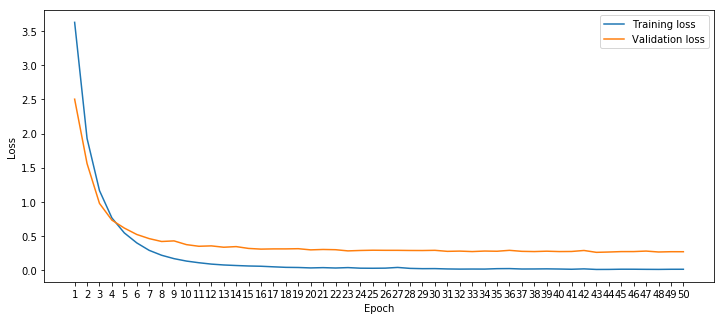

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,5))
epoch_list = np.arange(1, num_epochs+1)
plt.xticks(epoch_list)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.plot(epoch_list, train_losses, label="Training loss")
plt.plot(epoch_list, val_losses, label="Validation loss")
plt.legend(loc='upper right')
plt.show()

In [6]:
model.eval()

correct = 0
with torch.no_grad():
    for _, batch in enumerate(test_loader):
        data = batch['image'].to(device)
        labels = batch['label'].long().to(device)
        result = model(data)
        pred = result.argmax(dim=1, keepdim=True)
        correct += pred.eq(labels.view_as(pred)).sum().item()
    
print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(correct, len(test_loader.dataset), 
                                                       100. * correct / len(test_loader.dataset)))   


Test set: Accuracy: 1522/1639 (93%)

